# Prototype 01
## Experiment 03

## Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

## Training on Local Machine

In [1]:
executed_yet = False

In [2]:
import os

if not executed_yet:
    executed_yet = True
    original_working_directory_path = os.getcwd()
    os.chdir(os.path.join(original_working_directory_path, "../.."))
    root_working_directory_path =  os.getcwd()
    
print(f'Original working directory: {original_working_directory_path}')
print(f'Current working directory: {root_working_directory_path}')

Original working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_01
Current working directory: /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


## --- Dependencies ---

In [3]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [4]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.enums import Execution, Evaluation
from src.data_provider import DataProvider
from src.functions import calculate_balance_metrics, split_training_data
#from src.agent import Agent
#from src.simulation_engine import SimulationEngine
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent_on_afterstates

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from prototypes.prototype_01.environment import Environment
from prototypes.prototype_01.deep_q_network import DeepQNetwork
from prototypes.prototype_01.agent import Agent
from prototypes.prototype_01.client import Client

from prototypes.prototype_01.server import Server
from prototypes.prototype_02.experiment import Experiment

In [6]:
from src.sampling_probabilities import unit_sampling_probabilities, regular_sampling_probabilities, inverted_sampling_probabilities, \
    weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, \
    medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, \
    strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02

## --- Hyperparameters ---

In [7]:
import torch.nn as nn
import torch

def run_sample_distribution_experiment(experiment_id, experiment_version, nr_clients, training_data_strides, sampling_probabilities_01, sampling_probabilities_02):
    experiment = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
    experiment_path = experiment.get_experiment_path()

    # HYPERPARAMETER for Federated Learning
    NR_CLIENTS = nr_clients
    NR_ROUNDS = 30
    NR_EPISODES_PER_ROUND = 100
    NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

    # DQN Architecture Hyperparameter
    N_ACTIONS = len(MTDTechnique)
    N_HIDDEN_1 = 128
    N_HIDDEN_2 = 64
    N_HIDDEN_3 = 32
    N_FEATURES = rl_training_data_dict[Behavior.NORMAL].shape[1] -1

    # DQN Training Hyperparameter
    GAMMA = 0.5 #0.99 # discount factor for future rewards
    LR = 1e-3
    BATCH_SIZE = 32
    TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
    BUFFER_SIZE = 500
    MIN_REPLAY_SIZE = 100

    #SCHEDULER = 
    LOSS=nn.MSELoss()
    L2 = 0.01

    # HYPERPARAMETER for Epsilon Delta Strategy
    EPSILON_START = 1.0
    EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
    EPSILON_END = 0.01

    calculate_balance_metrics(sampling_probabilities_01, sampling_probabilities_02, NR_EPISODES_PER_CLIENT)

    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

    clients = []
    for i in range(NR_CLIENTS):
        entity_id = i + 1
        if entity_id % 2 == 0:
            SAMPLING_PROBABILITIES = sampling_probabilities_01
        else:
            SAMPLING_PROBABILITIES = sampling_probabilities_02
            
        environment = Environment(entity_id, training_data_strides[i], sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
        deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
        optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
        agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
        client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
        server.add_client(client)


    evaluations = [Evaluation.GLOBAL_PERFORMANCE_EVALUATION]
    #server.run_federation(evaluations=evaluations, evaluation_frequency=1)
    experiment.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)
    return experiment

In [8]:
def show_learning_curves(experiment):
    experiment.server.plot_learning_curves()

In [9]:
def show_experiment_graphs(experiment):
    experiment.plot_behavior_performances()
    experiment.plot_test_performances()
    experiment.plot_class_weighted_test_accuracy()

----------

## Experiment

In [10]:
rl_training_data_dict, rl_test_data_dict, _ = DataProvider.get_scaled_train_test_split_one(split=0.8, scaling_minmax=True, scale_normal_only=True)

training_data_strides = split_training_data(rl_training_data_dict, 10)

In [11]:
n_total_samples = 0
for key, value in rl_training_data_dict.items():
    print(f"{key} => {len(value)}")
    n_total_samples+=len(value)
print(f"There is a total of {n_total_samples} training samples")

Behavior.NORMAL => 8263
Behavior.RANSOMWARE_POC => 5320
Behavior.ROOTKIT_BDVL => 2586
Behavior.ROOTKIT_BEURK => 3826
Behavior.CNC_THETICK => 4081
Behavior.CNC_BACKDOOR_JAKORITAR => 2085
Behavior.CNC_OPT1 => 3030
Behavior.CNC_OPT2 => 2108
There is a total of 31299 training samples


In [15]:
import torch.nn as nn
import torch

experiment_id = 1
experiment_version = 0
e1v0 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v0.get_experiment_path()

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 10
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 100
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 128
N_HIDDEN_2 = 128
N_HIDDEN_3 = 16
N_FEATURES = rl_training_data_dict[Behavior.NORMAL].shape[1] -1
print(N_FEATURES)

# DQN Training Hyperparameter
GAMMA = 0.5 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01

SAMPLING_PROBABILITIES = attack_balanced_sampling_probabilities

calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, training_data_strides[i], sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v0.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

86
0.00125


NameError: name 'attack_balanced_sampling_probabilities' is not defined

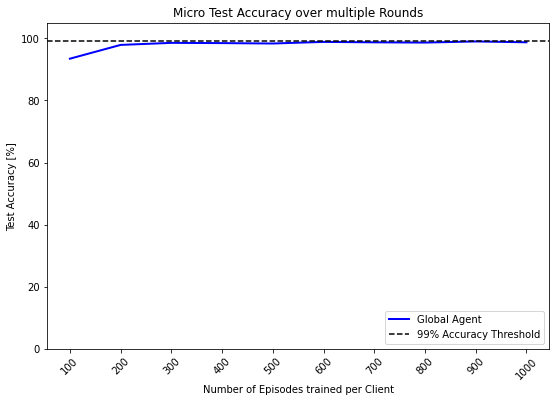

In [12]:
e1v0.plot_test_performances()

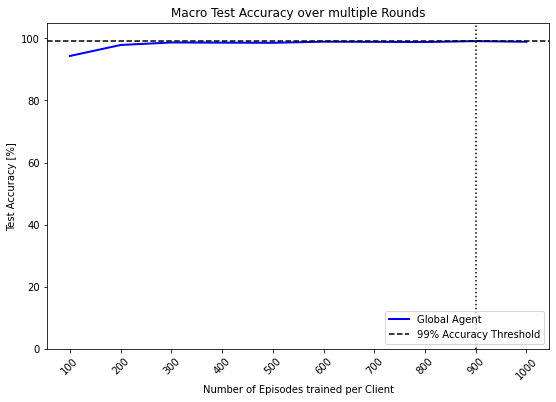

In [13]:
e1v0.plot_class_weighted_test_accuracy()

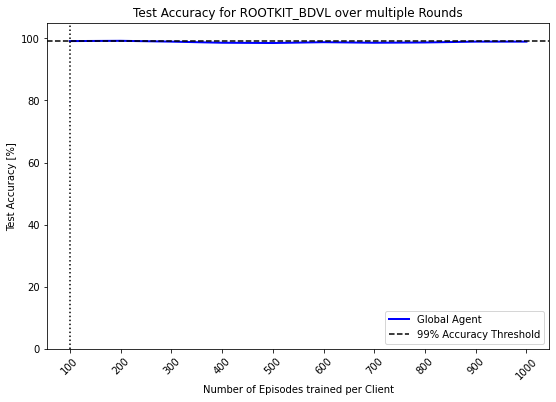

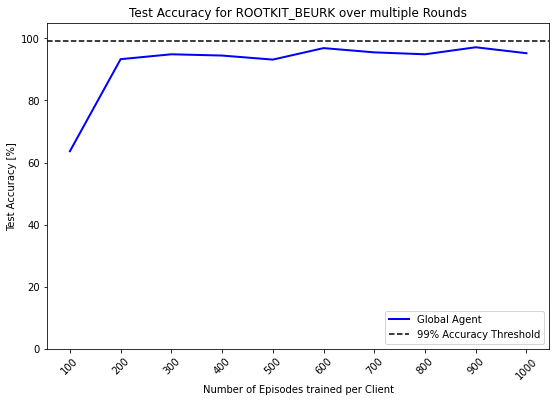

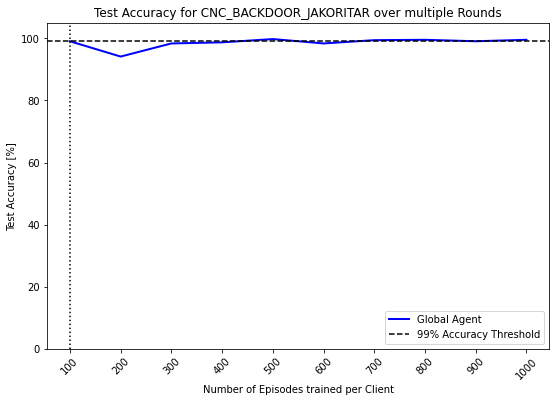

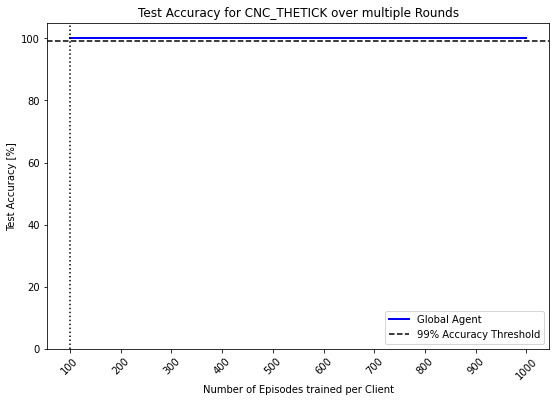

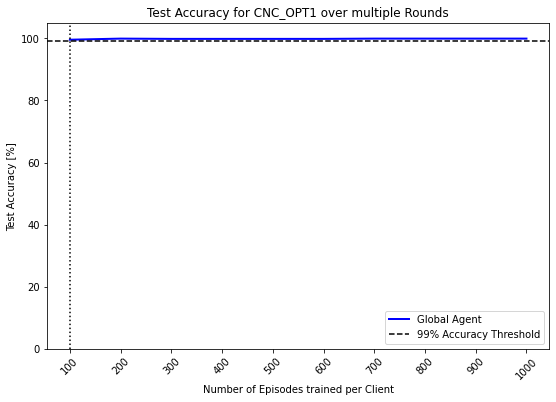

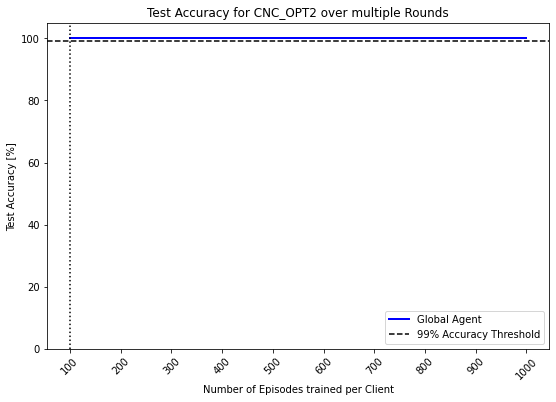

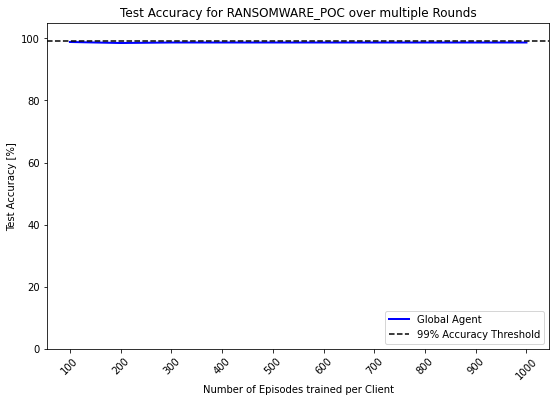

In [14]:
e1v0.plot_behavior_performances()

86
0.0004166666666666667
MID: 0.0
WCS: 1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=64, bias=True)
  (L3): Linear(in_features=64, out_features=32, bias=True)
  (L4): Linear(in_features=64, out_features=4, bias=True)
  (loss): MSELoss()
)
Starting Experiment 1.1
Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
PERFORMANCE EVALUATION
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.03 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Beh

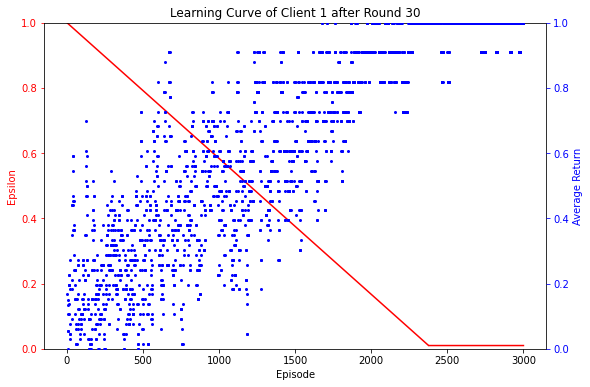

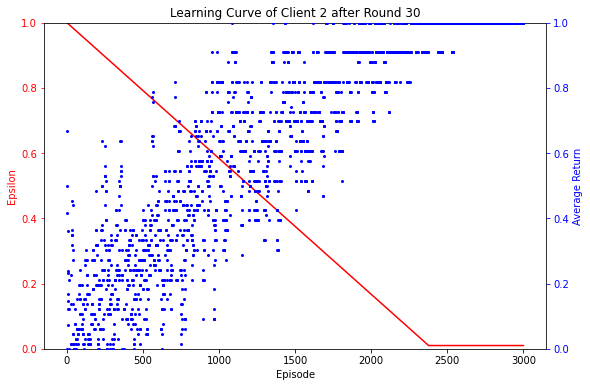

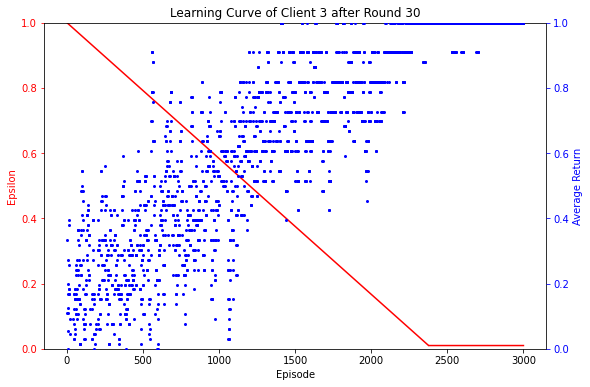

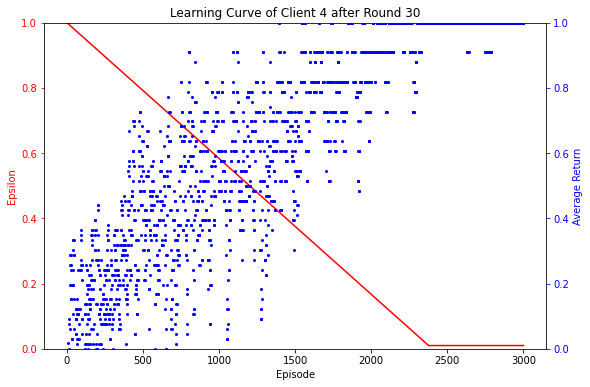

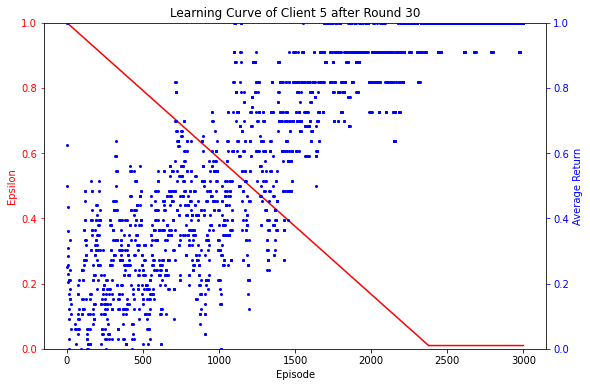

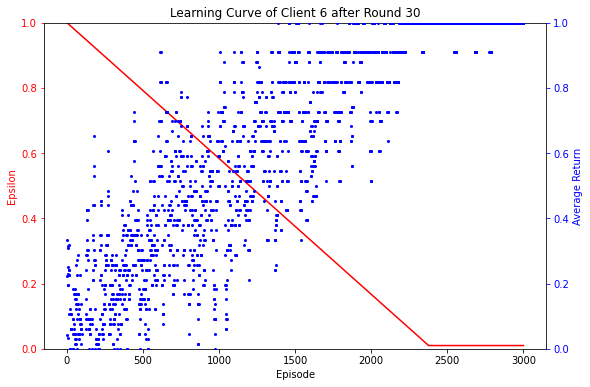

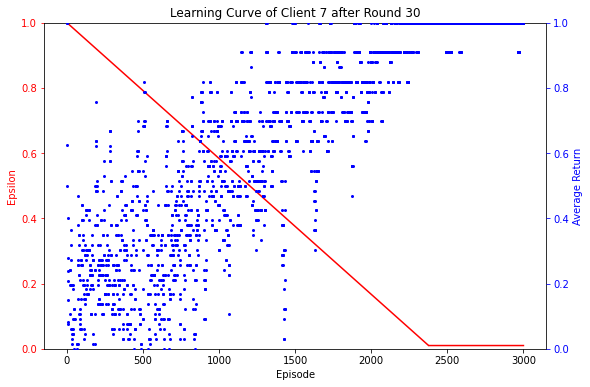

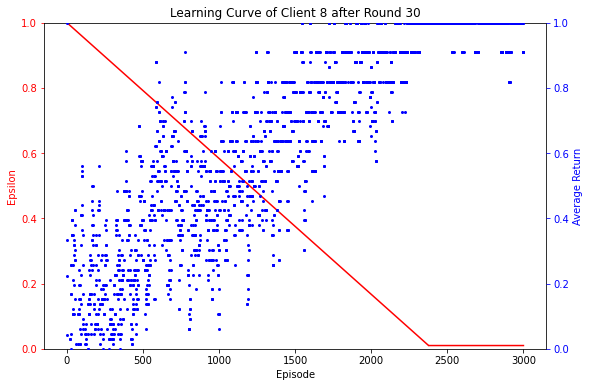

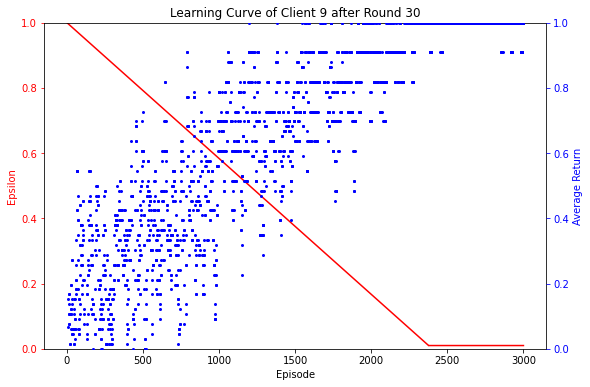

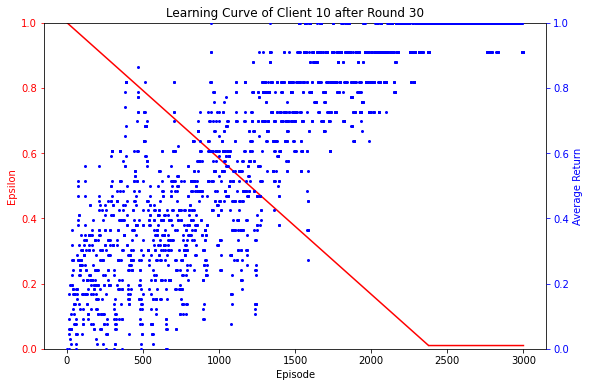

In [16]:
import torch.nn as nn
import torch

experiment_id = 1
experiment_version = 1
e1v1 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v1.get_experiment_path()

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 10
NR_ROUNDS = 30
NR_EPISODES_PER_ROUND = 100
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 128
N_HIDDEN_2 = 64
N_HIDDEN_3 = 32
N_FEATURES = rl_training_data_dict[Behavior.NORMAL].shape[1] -1
print(N_FEATURES)

# DQN Training Hyperparameter
GAMMA = 0.5 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01

SAMPLING_PROBABILITIES = attack_balanced_sampling_probabilities

calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, training_data_strides[i], sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v1.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

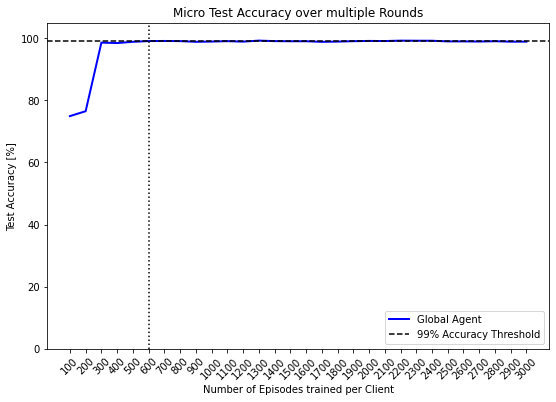

In [17]:
e1v1.plot_test_performances()

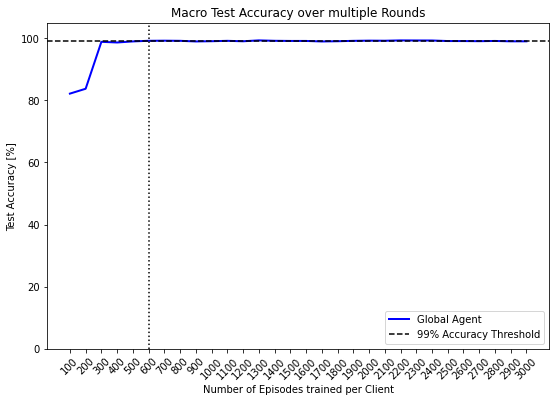

In [18]:
e1v1.plot_class_weighted_test_accuracy()

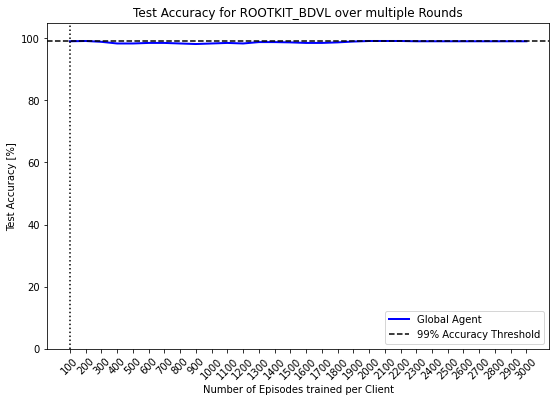

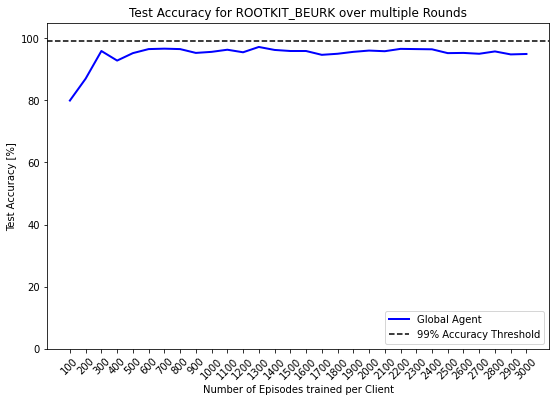

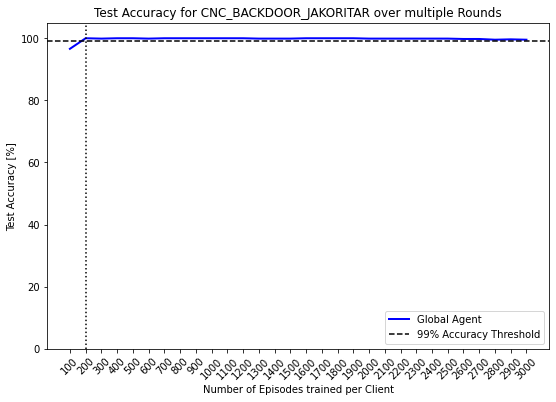

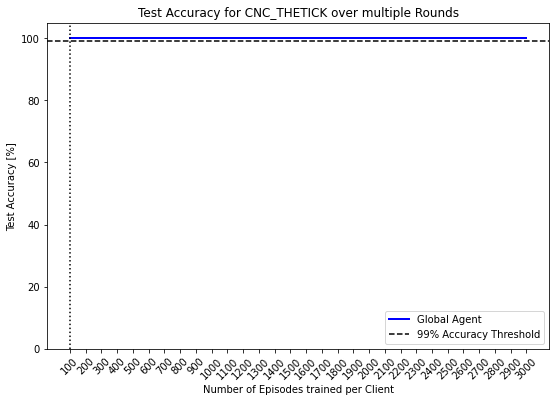

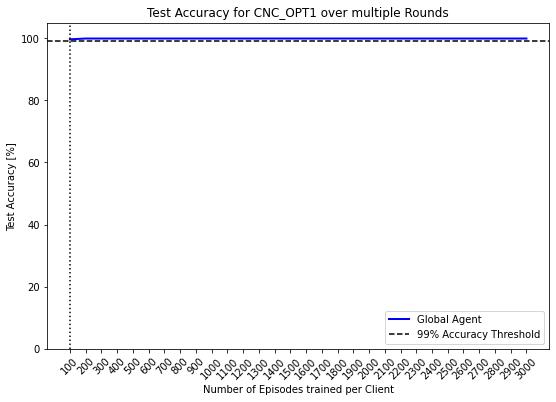

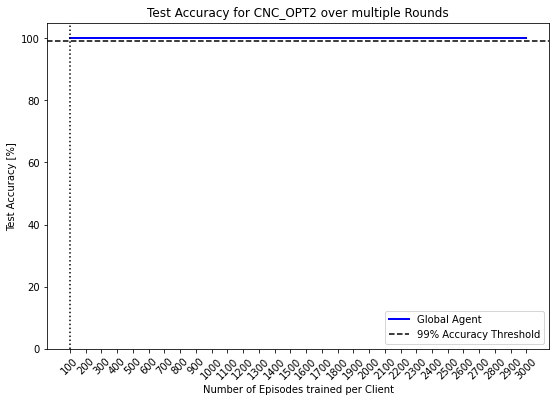

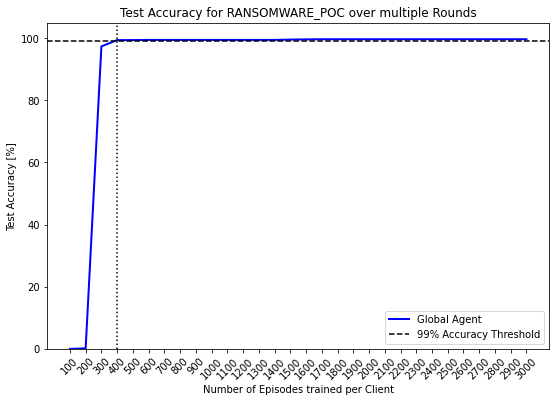

In [19]:
e1v1.plot_behavior_performances()

86
0.0004166666666666667
MID: 0.0
WCS: 1.0
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=64, bias=True)
  (L3): Linear(in_features=64, out_features=32, bias=True)
  (L4): Linear(in_features=64, out_features=4, bias=True)
  (loss): MSELoss()
)
Starting Experiment 1.1
Training each of the 1 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
PERFORMANCE EVALUATION
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |       0.27 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.2  | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Beha

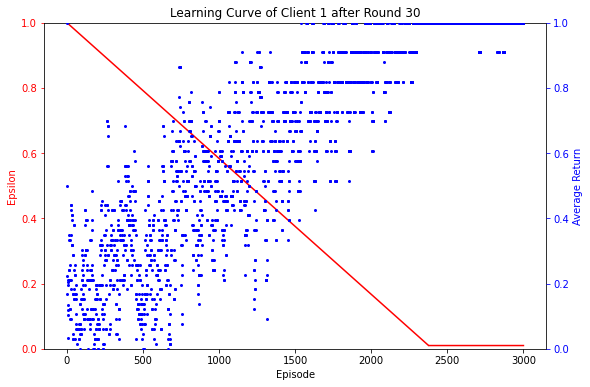

In [20]:
import torch.nn as nn
import torch

experiment_id = 1
experiment_version = 1
e1v2 = Experiment(base_path=original_working_directory_path, experiment_id=experiment_id, experiment_version=experiment_version)
experiment_path = e1v2.get_experiment_path()

# HYPERPARAMETER for Federated Learning
NR_CLIENTS = 1
NR_ROUNDS = 30
NR_EPISODES_PER_ROUND = 100
NR_EPISODES_PER_CLIENT = NR_ROUNDS * NR_EPISODES_PER_ROUND

# DQN Architecture Hyperparameter
N_ACTIONS = len(MTDTechnique)
N_HIDDEN_1 = 128
N_HIDDEN_2 = 64
N_HIDDEN_3 = 32
N_FEATURES = rl_training_data_dict[Behavior.NORMAL].shape[1] -1
print(N_FEATURES)

# DQN Training Hyperparameter
GAMMA = 0.5 #0.99 # discount factor for future rewards
LR = 1e-3
BATCH_SIZE = 32
TARGET_UPDATE_FREQ = NR_EPISODES_PER_ROUND - 1
BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100

#SCHEDULER = 
LOSS=nn.MSELoss()
L2 = 0.01


# HYPERPARAMETER for Epsilon Delta Strategy
EPSILON_START = 1.0
EPSILON_DEC = 1/(NR_EPISODES_PER_CLIENT*0.8)
print(EPSILON_DEC)
EPSILON_END = 0.01

SAMPLING_PROBABILITIES = attack_balanced_sampling_probabilities

calculate_balance_metrics(SAMPLING_PROBABILITIES, SAMPLING_PROBABILITIES, NR_EPISODES_PER_CLIENT)

deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
global_agent = Agent(0, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=None, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
server = Server(global_agent, rl_test_data_dict, experiment_id, experiment_path)

clients = []
for i in range(NR_CLIENTS):
    entity_id = i + 1
    environment = Environment(entity_id, rl_training_data_dict, sampling_probabilities=SAMPLING_PROBABILITIES , verbose=False)
    deep_q_network = DeepQNetwork(n_features=N_FEATURES, n_hidden_1=N_HIDDEN_1, n_hidden_2=N_HIDDEN_2, n_hidden_3=N_HIDDEN_3, n_actions=N_ACTIONS, loss=LOSS)
    optimizer = torch.optim.Adam(deep_q_network.parameters(), lr=LR,  weight_decay=L2, amsgrad=True)
    agent = Agent(entity_id, deep_q_network, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, gamma=GAMMA, optimizer=optimizer, eps=EPSILON_START, eps_min=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(entity_id, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.LEARNING_CURVE, Evaluation.GLOBAL_PERFORMANCE_EVALUATION]
#server.run_federation(evaluations=evaluations, evaluation_frequency=1)
e1v2.execute(server, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, evaluations=evaluations, evaluation_frequency=1)

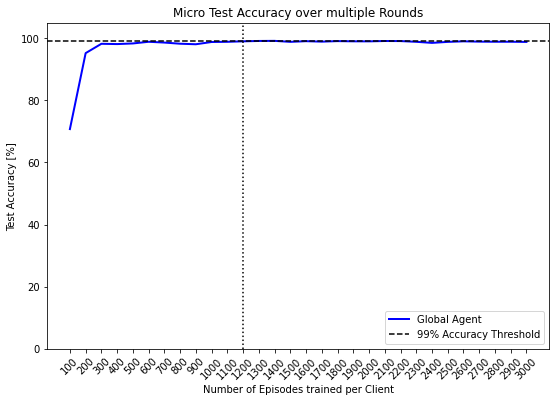

In [21]:
e1v2.plot_test_performances()

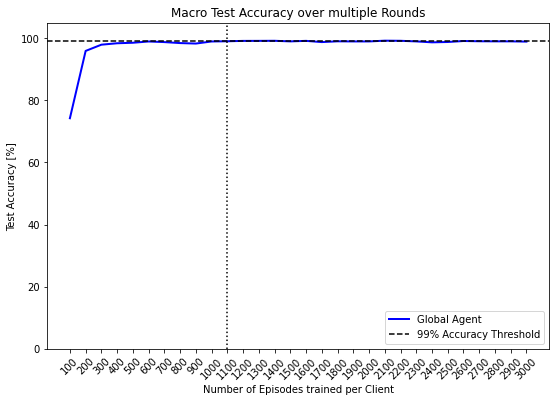

In [23]:
e1v2.plot_class_weighted_test_accuracy()

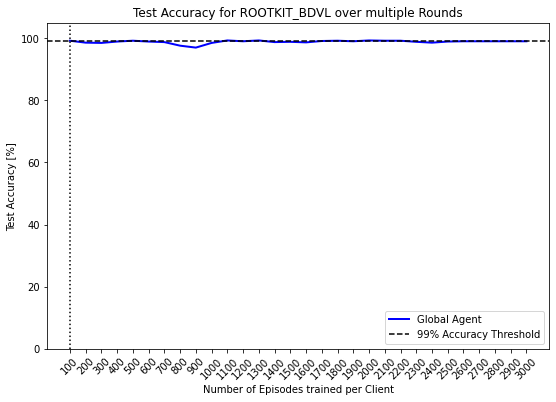

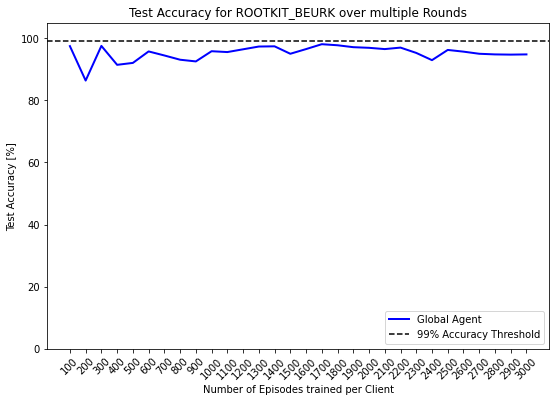

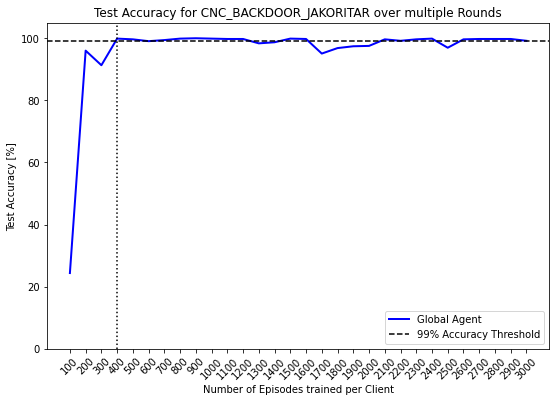

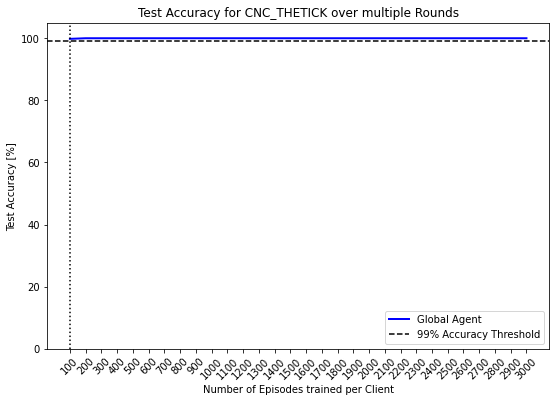

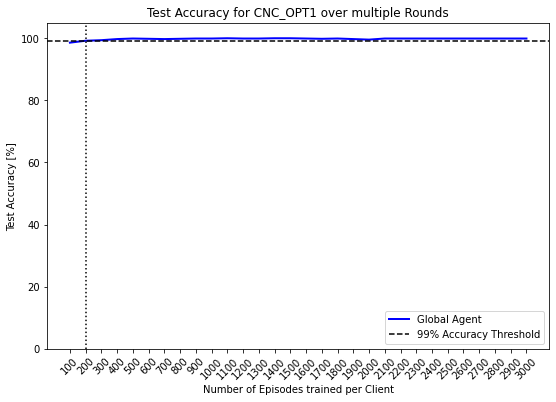

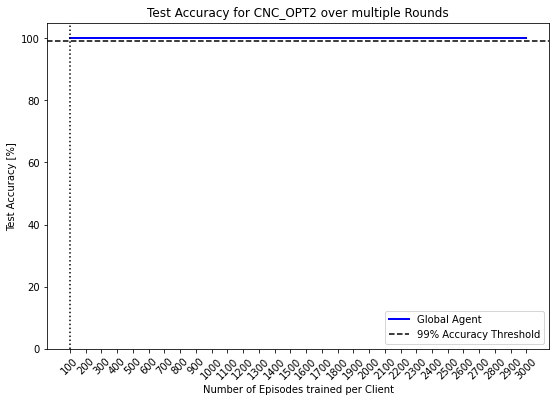

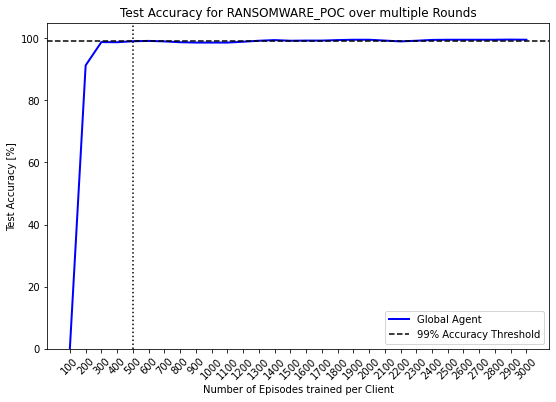

In [24]:
e1v2.plot_behavior_performances()

In [ ]:
run_sample_distribution_experiment(1, 5, training_data_strides, unit_sampling_probabilities, unit_sampling_probabilities)

---
## Scenario 05

In [12]:
e1v5 = run_sample_distribution_experiment(1, 5, 10, training_data_strides, weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02)

Dataset Balance Metrics: MID=0.0198 & WCS=0.9574
=== STARTING EXPERIMENT 1.5 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.

>>> SERVER TRAINING ROUND 1/30 <<<
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.RANSOMWARE_POC         |      98.98 | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |          1866 |
| Behavior.ROOTKIT_BDVL           |      99.38 | MTDTechnique.ROOTKIT_SANITIZER        |          1129 |
| Behavior.ROOTKIT_BEURK          |      72.76 | MTDTechnique.ROOTKIT_SANITIZER        |          1461 |
| Behavior.CNC_THETICK            |      99.87 | MTDTechnique.CNC_IP_SHUFFLE           |          1531 |
| Behavior.CNC_BACKDOOR_JAKORITAR |      89.79 | MTDTechnique.CNC_IP_SHUFFLE           |         

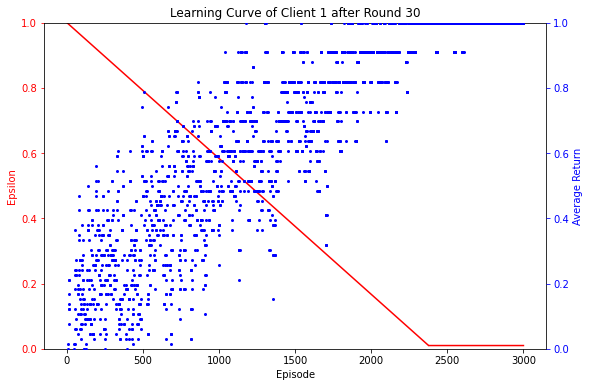

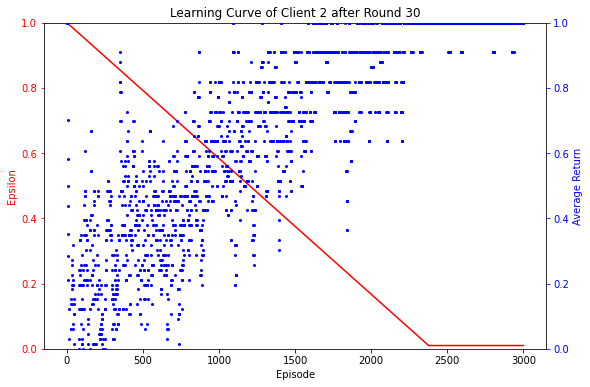

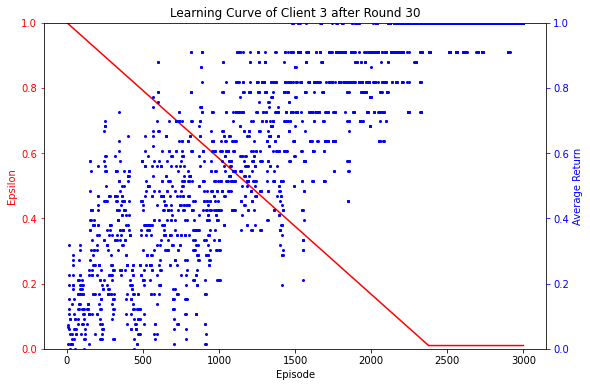

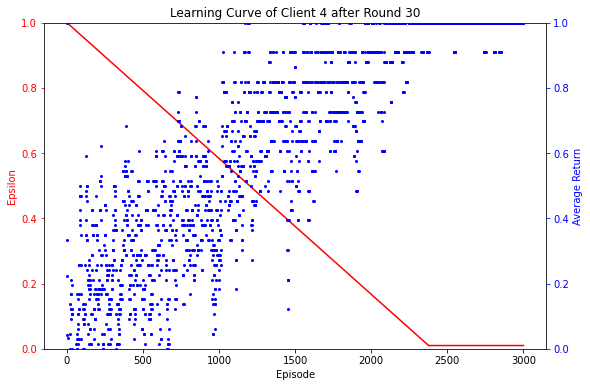

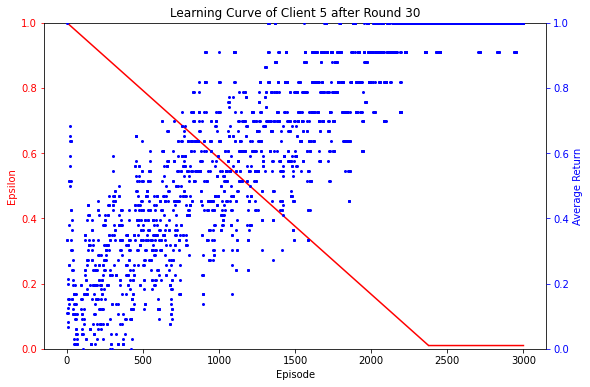

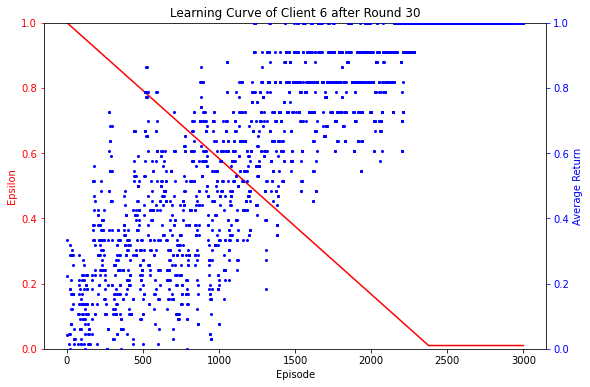

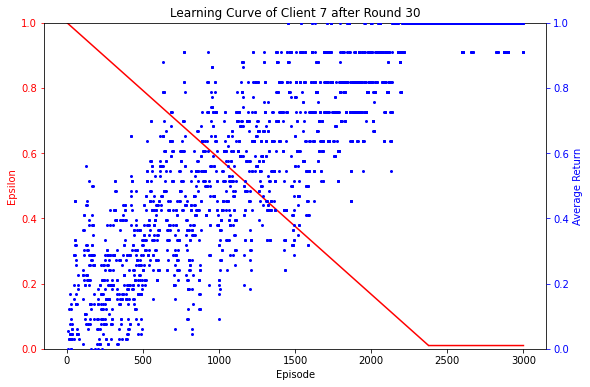

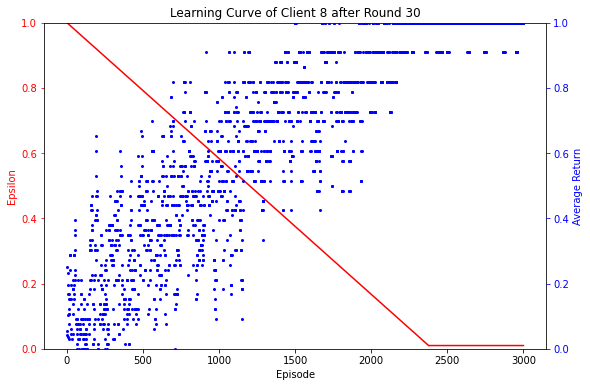

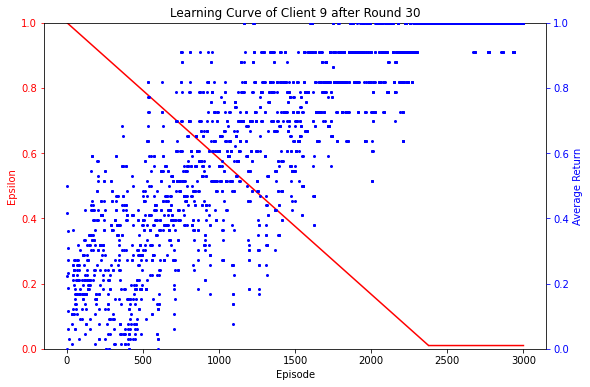

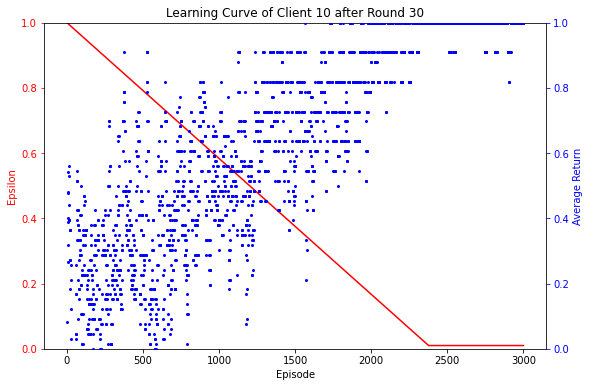

In [13]:
show_learning_curves(e1v5)

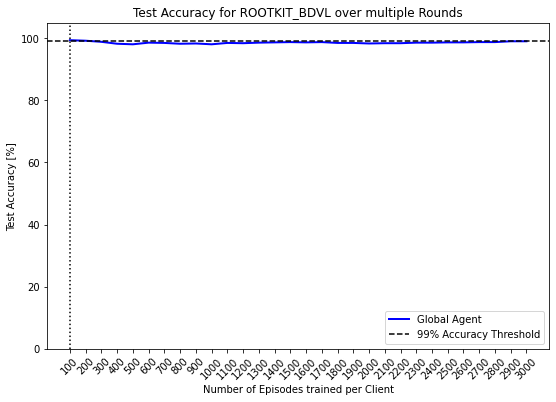

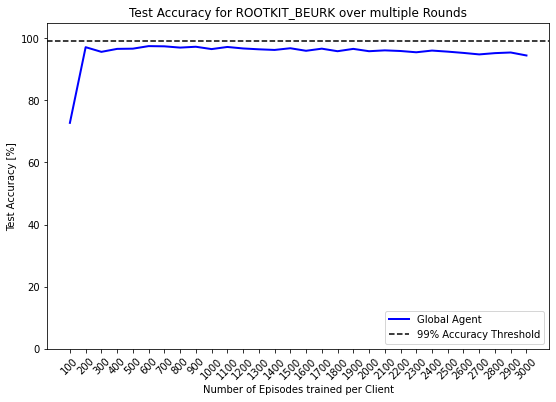

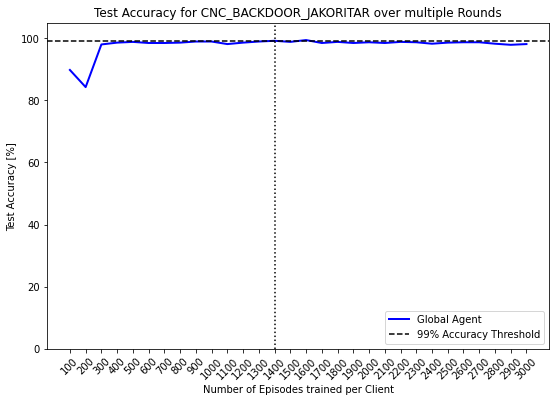

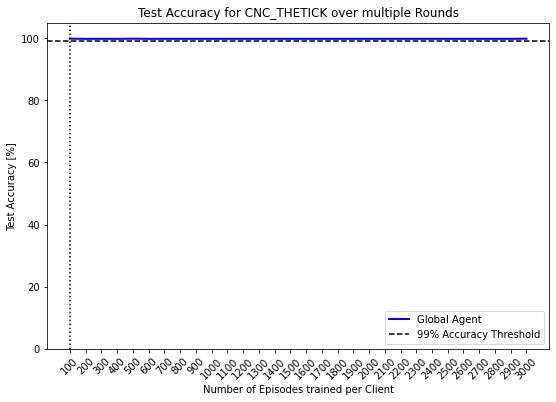

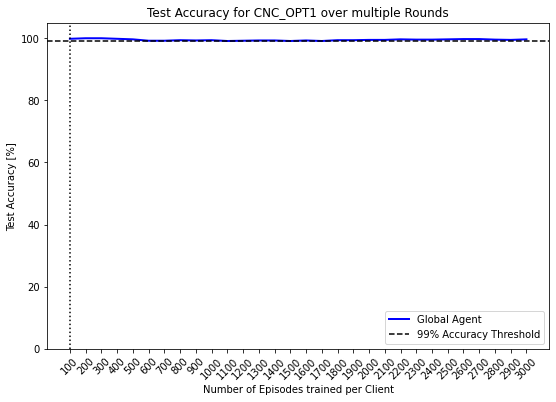

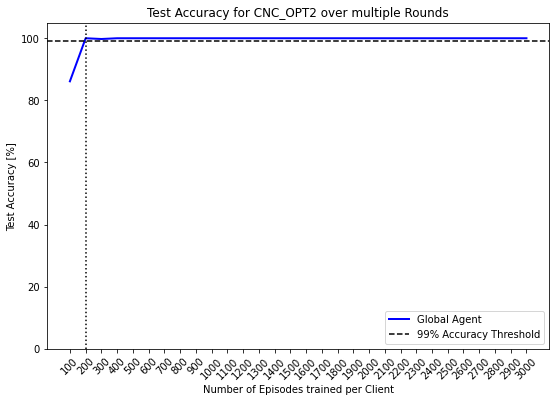

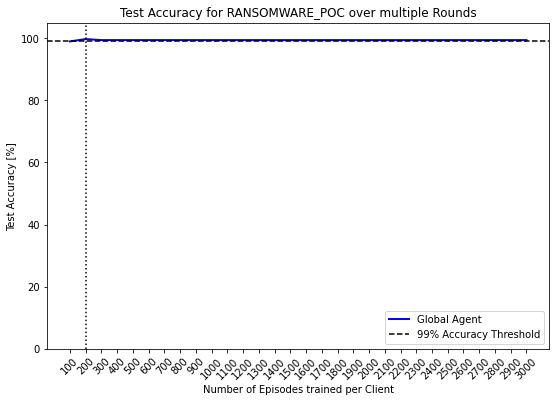

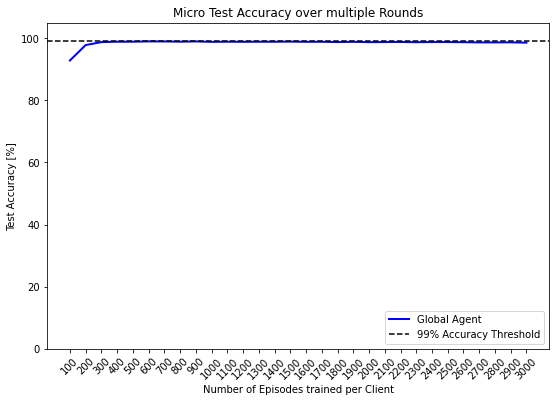

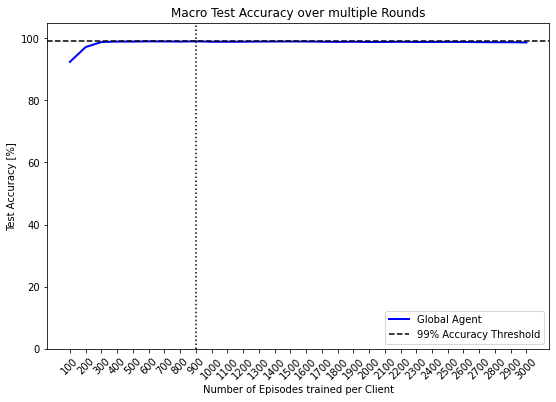

In [14]:
show_experiment_graphs(e1v5)

--- 
## Scenario 06

In [ ]:
e1v6 = run_sample_distribution_experiment(1, 6, training_data_strides, medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02)

---
## Scenario 07

In [ ]:
e1v7 = run_sample_distribution_experiment(1, 7, training_data_strides, strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02)